In [1]:
#import all needed libraries
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import calinski_harabasz_score
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Read the dataset
df1 = pd.read_csv('/content/drive/MyDrive/Datasets/database_gas.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Datasets/database_pos.csv')


In [4]:
#First 5 rows of dataset 1
df1.head()

timestamp  temperature  humidity  CO2CosIRValue  \
0  2019-11-06 11:37:13.038174+01:00        19.48     54.86          128.0   
1  2019-11-06 11:37:32.744996+01:00        19.59     54.23          129.0   
2  2019-11-06 11:37:53.018087+01:00        19.63     54.05          128.0   
3  2019-11-06 11:38:13.093151+01:00        19.64     53.74          128.0   
4  2019-11-06 11:38:33.032832+01:00        19.67     53.53          128.0   

   CO2MG811Value   MOX1   MOX2   MOX3   MOX4  COValue  
0          563.0  476.0  731.0  649.0  565.0    128.0  
1          563.0  477.0  731.0  649.0  565.0    125.0  
2          566.0  478.0  732.0  649.0  565.0    125.0  
3          566.0  478.0  732.0  649.0  565.0    125.0  
4          569.0  480.0  732.0  650.0  565.0    125.0

In [5]:
#First 5 rows of dataset 2
df2.head()

datetime  Living room  Bedroom  Bathroom  \
0  2019-11-01 02:52:55.271086300+00:00          NaN      0.0       NaN   
1  2019-11-01 03:19:57.417067700+00:00          NaN      1.0       NaN   
2  2019-11-01 03:21:53.257070700+00:00          NaN      0.0       NaN   
3     2019-11-01 05:11:08.874031+00:00          NaN      1.0       NaN   
4  2019-11-01 05:12:38.437033500+00:00          NaN      0.0       NaN   

   Kitchen  Hallway  
0      NaN      NaN  
1      NaN      NaN  
2      NaN      NaN  
3      NaN      NaN  
4      NaN      NaN

In [6]:
# Parse timestamps as datetime objects
df1['timestamp'] = pd.to_datetime(df1['timestamp'], utc=True)
df2['datetime'] = pd.to_datetime(df2['datetime'], utc=True)

In [7]:
# Merge the datasets on the nearest timestamps
merged_data = pd.merge_asof(df2.sort_values('datetime'), df1.sort_values('timestamp'),
                            left_on='datetime', right_on='timestamp', direction='nearest')

In [8]:
#First 50 rows
merged_data.head(50)

datetime  Living room  Bedroom  Bathroom  \
0  2019-11-01 02:52:55.271086300+00:00          NaN      0.0       NaN   
1  2019-11-01 03:19:57.417067700+00:00          NaN      1.0       NaN   
2  2019-11-01 03:21:53.257070700+00:00          NaN      0.0       NaN   
3     2019-11-01 05:11:08.874031+00:00          NaN      1.0       NaN   
4  2019-11-01 05:12:38.437033500+00:00          NaN      0.0       NaN   
5  2019-11-01 05:14:15.993041400+00:00          NaN      1.0       NaN   
6  2019-11-01 05:15:16.193075900+00:00          NaN      0.0       NaN   
7  2019-11-01 05:19:56.796071400+00:00          NaN      1.0       NaN   
8  2019-11-01 05:21:16.204047100+00:00          NaN      0.0       NaN   
9  2019-11-01 06:42:17.866021800+00:00          NaN      1.0       NaN   
10 2019-11-01 06:44:19.423095700+00:00          NaN      0.0       NaN   
11 2019-11-01 06:44:40.501085400+00:00          NaN      NaN       NaN   
12 2019-11-01 06:44:46.413047100+00:00          0.0      NaN       NaN   
13 2019-11-01 06:45:48.408012100+00:00          NaN      NaN       0.0   
14 2019-11-01 06:46:17.569052900+00:00          NaN      NaN       1.0   
15 2019-11-01 07:00:15.210071600+00:00          NaN      NaN       0.0   
16 2019-11-01 07:00:17.501032300+00:00          NaN      NaN       1.0   
17 2019-11-01 07:04:21.062036200+00:00          NaN      NaN       0.0   
18 2019-11-01 07:12:34.973078200+00:00          NaN      NaN       NaN   
19 2019-11-01 07:12:39.065045400+00:00          1.0      NaN       NaN   
20 2019-11-01 07:12:39.442017800+00:00          NaN      1.0       NaN   
21 2019-11-01 07:13:40.446027800+00:00          0.0      NaN       NaN   
22 2019-11-01 07:13:41.397048700+00:00          NaN      0.0       NaN   
23 2019-11-01 07:14:05.187063600+00:00          1.0      NaN       NaN   
24 2019-11-01 07:14:05.633024200+00:00          NaN      1.0       NaN   
25 2019-11-01 07:15:01.472071400+00:00          NaN      NaN       NaN   
26    2019-11-01 07:15:06.391040+00:00          NaN      0.0       NaN   
27    2019-11-01 07:15:06.711054+00:00          NaN      NaN       NaN   
28 2019-11-01 07:15:10.238058800+00:00          NaN      1.0       NaN   
29 2019-11-01 07:16:07.751083200+00:00          NaN      NaN       NaN   
30 2019-11-01 07:16:11.142072800+00:00          NaN      0.0       NaN   
31 2019-11-01 07:16:40.416001600+00:00          0.0      NaN       NaN   
32 2019-11-01 07:20:52.712057800+00:00          1.0      NaN       NaN   
33 2019-11-01 07:20:57.146056500+00:00          NaN      NaN       NaN   
34 2019-11-01 07:21:54.679077500+00:00          0.0      NaN       NaN   
35 2019-11-01 07:21:57.453068600+00:00          NaN      NaN       NaN   
36 2019-11-01 08:37:06.403038800+00:00          NaN      NaN       NaN   
37 2019-11-01 08:37:11.092019200+00:00          1.0      NaN       NaN   
38 2019-11-01 08:38:07.677097600+00:00          NaN      NaN       NaN   
39 2019-11-01 08:38:12.633020400+00:00          0.0      NaN       NaN   
40 2019-11-01 08:44:36.636009400+00:00          NaN      NaN       NaN   
41 2019-11-01 08:48:17.034095100+00:00          1.0      NaN       NaN   
42 2019-11-01 08:49:01.663023500+00:00          NaN      NaN       NaN   
43 2019-11-01 08:49:49.632008600+00:00          0.0      NaN       NaN   
44 2019-11-01 08:49:57.991032400+00:00          1.0      NaN       NaN   
45 2019-11-01 08:50:08.084076600+00:00          NaN      NaN       NaN   
46 2019-11-01 08:50:12.145028400+00:00          NaN      NaN       1.0   
47 2019-11-01 08:50:59.344005200+00:00          0.0      NaN       NaN   
48 2019-11-01 08:51:08.622022100+00:00          NaN      NaN       NaN   
49 2019-11-01 08:51:40.245081600+00:00          NaN      NaN       0.0   

    Kitchen  Hallway                        timestamp  temperature  humidity  \
0       NaN      NaN 2019-11-06 10:37:13.038174+00:00        19.48     54.86   
1       NaN      NaN 2019-11-06 10:37:13.038174+00:00        19.48     54.86   
2       NaN    

In [9]:
#Shape of Dataset
merged_data.shape

(28478, 16)

In [10]:
# Fill missing values in the merged data using backfill
merged_data.fillna(method='ffill', inplace=True)  # Forward fill
merged_data.fillna(method='bfill', inplace=True)  # Backward fill


In [11]:
#Checking null values
merged_data.isnull().sum()

datetime         0
Living room      0
Bedroom          0
Bathroom         0
Kitchen          0
Hallway          0
timestamp        0
temperature      0
humidity         0
CO2CosIRValue    0
CO2MG811Value    0
MOX1             0
MOX2             0
MOX3             0
MOX4             0
COValue          0
dtype: int64

In [12]:
# Perform anomaly detection using Isolation Forest
features = ['temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value', 'MOX1', 'MOX2', 'MOX3', 'MOX4', 'COValue']
X = merged_data[features]
clf = IsolationForest(contamination=0.05, random_state=42)
merged_data['anomaly'] = clf.fit_predict(X)

print(merged_data)

                                 datetime  Living room  Bedroom  Bathroom  \
0     2019-11-01 02:52:55.271086300+00:00          0.0      0.0       0.0   
1     2019-11-01 03:19:57.417067700+00:00          0.0      1.0       0.0   
2     2019-11-01 03:21:53.257070700+00:00          0.0      0.0       0.0   
3        2019-11-01 05:11:08.874031+00:00          0.0      1.0       0.0   
4     2019-11-01 05:12:38.437033500+00:00          0.0      0.0       0.0   
...                                   ...          ...      ...       ...   
28473 2020-02-13 17:04:38.956087800+00:00          1.0      0.0       0.0   
28474 2020-02-13 17:05:29.384067600+00:00          1.0      0.0       1.0   
28475 2020-02-13 17:06:21.575053600+00:00          0.0      0.0       1.0   
28476 2020-02-13 17:06:30.519011100+00:00          0.0      0.0       0.0   
28477 2020-02-13 17:06:30.833050100+00:00          0.0      0.0       0.0   

       Kitchen  Hallway                        timestamp  temperature  \
0 

In [13]:
#Normalize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [14]:
# Define a custom scorer
def custom_scorer(clf, X, y):
    predicted_labels = clf.predict(X)
    accuracy = accuracy_score(y, predicted_labels)
    return accuracy

# Create the Isolation Forest model
clf = IsolationForest(contamination=0.05, random_state=42)

# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.8, 1.0]
}

# Create GridSearchCV with the custom scorer
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring=make_scorer(custom_scorer))
grid_search.fit(X_scaled)

# Get the best estimator from the grid search
best_clf = grid_search.best_estimator_



In [15]:
# Convert predictions to 0 for normal instances and 1 for anomalies
y_pred = best_clf.predict(X_scaled)
isolation_forest_outliers = [1 if label == -1 else 0 for label in y_pred]

# Ground truth labels (1 for anomalies, 0 for normal)
y_true = [1 if is_anomaly else 0 for is_anomaly in isolation_forest_outliers]

In [16]:
# Calculate accuracy
accuracy = accuracy_score(y_true, isolation_forest_outliers)

# Calculate precision
precision = precision_score(y_true, isolation_forest_outliers)

# Calculate recall
recall = recall_score(y_true, isolation_forest_outliers)

# Calculate F1-score
f1 = f1_score(y_true, isolation_forest_outliers)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')

Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


In [17]:
# Print the rows where anomalies are detected (-1 indicates anomalies)
anomalies = merged_data[merged_data['anomaly'] == -1]
print("Anomalies:")
print(anomalies)

Anomalies:
                                 datetime  Living room  Bedroom  Bathroom  \
2037  2019-11-08 07:39:07.476026300+00:00          0.0      0.0       0.0   
2038  2019-11-08 07:39:11.531018400+00:00          1.0      0.0       0.0   
2039  2019-11-08 07:40:08.426096100+00:00          1.0      0.0       0.0   
2040  2019-11-08 07:41:00.500066900+00:00          0.0      0.0       0.0   
2041  2019-11-08 07:42:08.091095400+00:00          1.0      0.0       0.0   
...                                   ...          ...      ...       ...   
25790 2020-02-04 11:45:57.049053100+00:00          1.0      0.0       0.0   
25791 2020-02-04 11:46:14.301042500+00:00          1.0      0.0       1.0   
25792 2020-02-04 11:46:14.906003200+00:00          1.0      0.0       1.0   
25793 2020-02-04 11:46:15.848053600+00:00          1.0      1.0       1.0   
25794 2020-02-04 11:47:48.371034100+00:00          1.0      0.0       1.0   

       Kitchen  Hallway                        timestamp  temper

In [18]:
#Checking the columns
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28478 entries, 0 to 28477
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   datetime       28478 non-null  datetime64[ns, UTC]
 1   Living room    28478 non-null  float64            
 2   Bedroom        28478 non-null  float64            
 3   Bathroom       28478 non-null  float64            
 4   Kitchen        28478 non-null  float64            
 5   Hallway        28478 non-null  float64            
 6   timestamp      28478 non-null  datetime64[ns, UTC]
 7   temperature    28478 non-null  float64            
 8   humidity       28478 non-null  float64            
 9   CO2CosIRValue  28478 non-null  float64            
 10  CO2MG811Value  28478 non-null  float64            
 11  MOX1           28478 non-null  float64            
 12  MOX2           28478 non-null  float64            
 13  MOX3           28478 non-null  float64        

In [19]:
# Count the number of anomalies detected
num_anomalies = len(anomalies)
print(f"Number of anomalies detected: {num_anomalies}")

Number of anomalies detected: 1424


In [20]:
# Analyze anomalies by specific rooms
anomalies_by_room = anomalies.groupby('Living room')['anomaly'].count()
print("Anomalies by Room:")
print(anomalies_by_room)


Anomalies by Room:
Living room
0.0    552
1.0    872
Name: anomaly, dtype: int64


In [21]:
# Analyze anomalies by Kitchen
anomalies_by_room = anomalies.groupby('Kitchen')['anomaly'].count()
print("Anomalies by Room:")
print(anomalies_by_room)

Anomalies by Room:
Kitchen
0.0    763
1.0    661
Name: anomaly, dtype: int64


In [24]:
#  Trigger actions based on detected anomalies
for index, row in anomalies.iterrows():
    print(f"Anomaly detected in {row['Kitchen']} at {row['timestamp']}. Triggering alert/notification...")


Anomaly detected in 0.0 at 2019-11-08 07:39:06.141644+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:39:06.141644+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:40:06.411090+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:41:06.494120+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:42:06.026136+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:42:06.026136+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:43:06.319938+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:43:06.319938+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:43:06.319938+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 07:44:06.472216+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-11-08 08:30:06.256383+00:00.

In [22]:
# Statistical analysis of anomalies (mean, standard deviation, etc.)
anomalies_stats = anomalies[features].describe()
print("Anomalies Statistics:")
print(anomalies_stats)


Anomalies Statistics:
       temperature     humidity  CO2CosIRValue  CO2MG811Value         MOX1  \
count  1424.000000  1424.000000    1424.000000    1424.000000  1424.000000   
mean     21.874712    52.860449     273.283006     518.336376   451.260534   
std       3.361348     6.585290     171.146058      63.605877    96.375985   
min      13.980000    40.460000      57.000000     420.000000   268.000000   
25%      18.000000    46.300000      69.000000     473.000000   377.000000   
50%      23.590000    54.750000     296.000000     488.000000   418.000000   
75%      24.290000    58.592500     409.000000     571.000000   566.250000   
max      26.080000    66.730000     591.000000     632.000000   622.000000   

              MOX2         MOX3         MOX4      COValue  
count  1424.000000  1424.000000  1424.000000  1424.000000  
mean    642.742978   593.514045   517.622191   315.167837  
std     101.396489   111.619906   127.816356   201.990664  
min     514.000000   454.000000   3

In [25]:
# Convert timestamp columns to datetime
merged_data['datetime'] = pd.to_datetime(merged_data['datetime'])
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])

Anomaly detected in 0.0 at 2019-12-31 23:51:47.146364+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:51:47.146364+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:52:26.983528+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:53:07.005930+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:53:27.012184+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:54:27.302065+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:56:47.017869+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:57:06.984272+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:58:46.985107+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2019-12-31 23:59:27.286586+00:00. Triggering alert/notification...
Anomaly detected in 0.0 at 2020-01-01 00:00:28.142480+00:00.

In [23]:
# Visualize anomalies in specific features (e.g., temperature)
plt.figure(figsize=(8, 6))
plt.hist(anomalies['temperature'], bins=20, color='red', alpha=0.7, label='Anomalies')
plt.hist(merged_data['temperature'], bins=20, color='blue', alpha=0.7, label='Normal')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.title('Anomaly Detection: Temperature Distribution')
plt.show()


In [28]:
merged_data

datetime  Living room  Bedroom  Bathroom  \
0     2019-11-01 02:52:55.271086300+00:00          0.0      0.0       0.0   
1     2019-11-01 03:19:57.417067700+00:00          0.0      1.0       0.0   
2     2019-11-01 03:21:53.257070700+00:00          0.0      0.0       0.0   
3        2019-11-01 05:11:08.874031+00:00          0.0      1.0       0.0   
4     2019-11-01 05:12:38.437033500+00:00          0.0      0.0       0.0   
...                                   ...          ...      ...       ...   
28473 2020-02-13 17:04:38.956087800+00:00          1.0      0.0       0.0   
28474 2020-02-13 17:05:29.384067600+00:00          1.0      0.0       1.0   
28475 2020-02-13 17:06:21.575053600+00:00          0.0      0.0       1.0   
28476 2020-02-13 17:06:30.519011100+00:00          0.0      0.0       0.0   
28477 2020-02-13 17:06:30.833050100+00:00          0.0      0.0       0.0   

       Kitchen  Hallway                        timestamp  temperature  \
0          0.0      0.0 2019-11-06 10:37:13.038174+00:00        19.48   
1          0.0      0.0 2019-11-06 10:37:13.038174+00:00        19.48   
2          0.0      0.0 2019-11-06 10:37:13.038174+00:00        19.48   
3          0.0      0.0 2019-11-06 10:37:13.038174+00:00        19.48   
4          0.0      0.0 2019-11-06 10:37:13.038174+00:00        19.48   
...        ...      ...                              ...          ...   
28473      0.0      1.0 2020-02-13 10:58:14.014336+00:00        20.62   
28474      0.0      1.0 2020-02-13 10:58:14.014336+00:00        20.62   
28475      0.0      1.0 2020-02-13 10:58:14.014336+00:00        20.62   
28476      0.0      1.0 2020-02-13 10:58:14.014336+00:00        20.62   
28477      0.0      0.0 2020-02-13 10:58:14.014336+00:00        20.62   

       humidity  CO2CosIRValue  CO2MG811Value   MOX1   MOX2   MOX3   MOX4  \
0         54.86          128.0          563.0  476.0  731.0  649.0  565.0   
1         54.86          128.0          563.0  476.0  731.0  649.0  565.0   
2         54.86          128.0          563.0  476.0  731.0  649.0  565.0   
3         54.86          128.0          563.0  476.0  731.0  649.0  565.0   
4         54.86          128.0          563.0  476.0  731.0  649.0  565.0   
...         ...            ...            ...    ...    ...    ...    ...   
28473     57.74           63.0          518.0  524.0  698.0  641.0  591.0   
28474     57.74           63.0          518.0  524.0  698.0  641.0  591.0   
28475     57.74           63.0          518.0  524.0  698.0  641.0  591.0   
28476     57.74           63.0          518.0  524.0  698.0  641.0  591.0   
28477     57.74           63.0          518.0  524.0  698.0  641.0  591.0   

       COValue  anomaly  
0        128.0        1  
1        128.0        1  
2        128.0        1  
3        128.0        1  
4        128.0        1  
...        ...      ...  
28473    157.0        1  
28474    157.0        1  
28475    157.0        1  
28476    157.0        1  
28477    157.0        1  

[28478 rows x 17 columns]

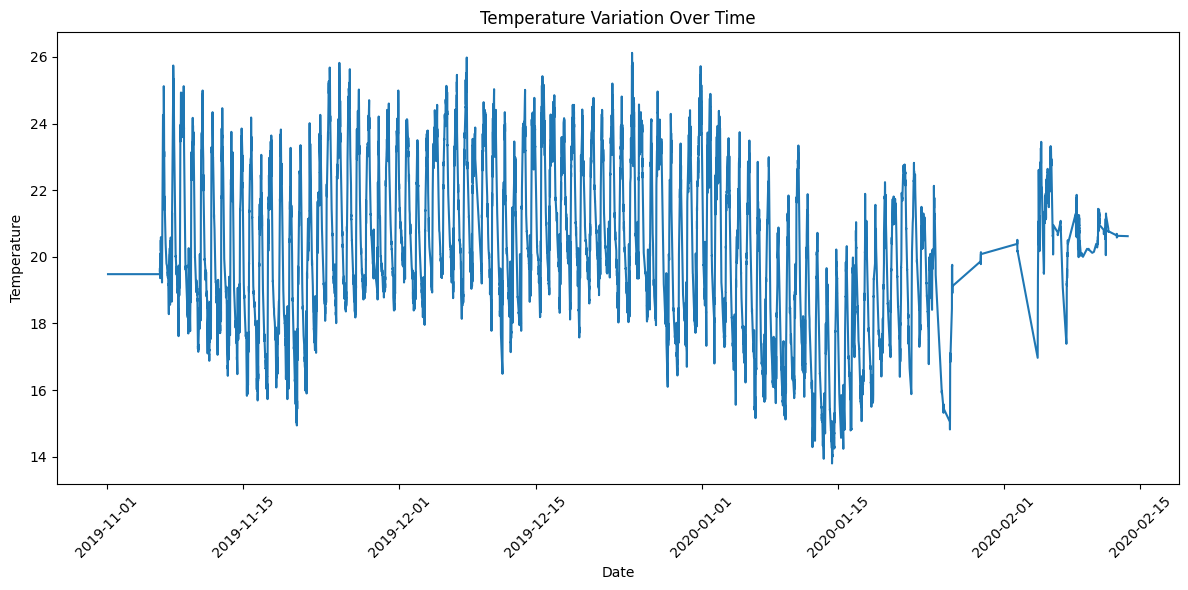

In [30]:
# Visualization: Line plot for temperature variation over time
plt.figure(figsize=(12, 6))
sns.lineplot(x='datetime', y='temperature', data=merged_data)
plt.title('Temperature Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Visualization: Countplot for anomaly occurrences
sns.countplot(x='anomaly', data=merged_data, order=[-1, 1])
plt.title('Count of Anomalies')
plt.xlabel('Anomaly')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Anomaly', 'Normal'])
plt.tight_layout()
plt.show()



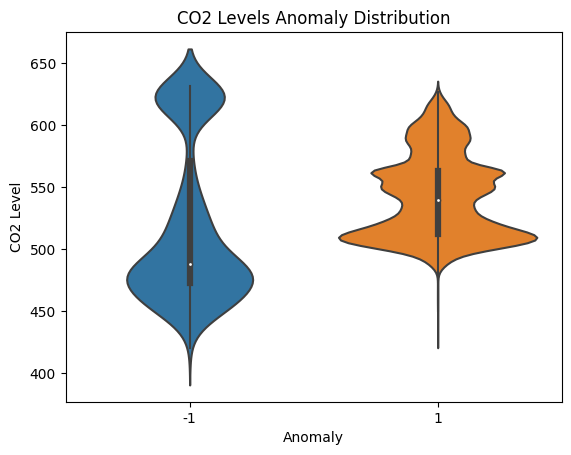

In [32]:
sns.violinplot(x='anomaly', y='CO2MG811Value', data=merged_data)
plt.title('CO2 Levels Anomaly Distribution')
plt.xlabel('Anomaly')
plt.ylabel('CO2 Level')
plt.show()


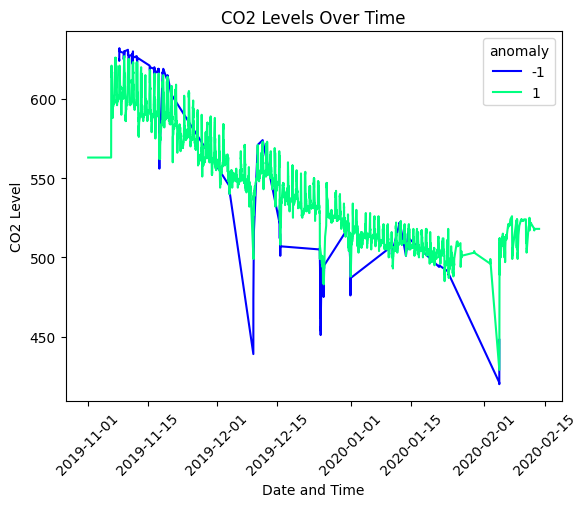

In [33]:
#Lineplot
sns.lineplot(x='datetime', y='CO2MG811Value', hue='anomaly', data=merged_data, palette='winter')
plt.title('CO2 Levels Over Time')
plt.xlabel('Date and Time')
plt.ylabel('CO2 Level')
plt.xticks(rotation=45)
plt.show()


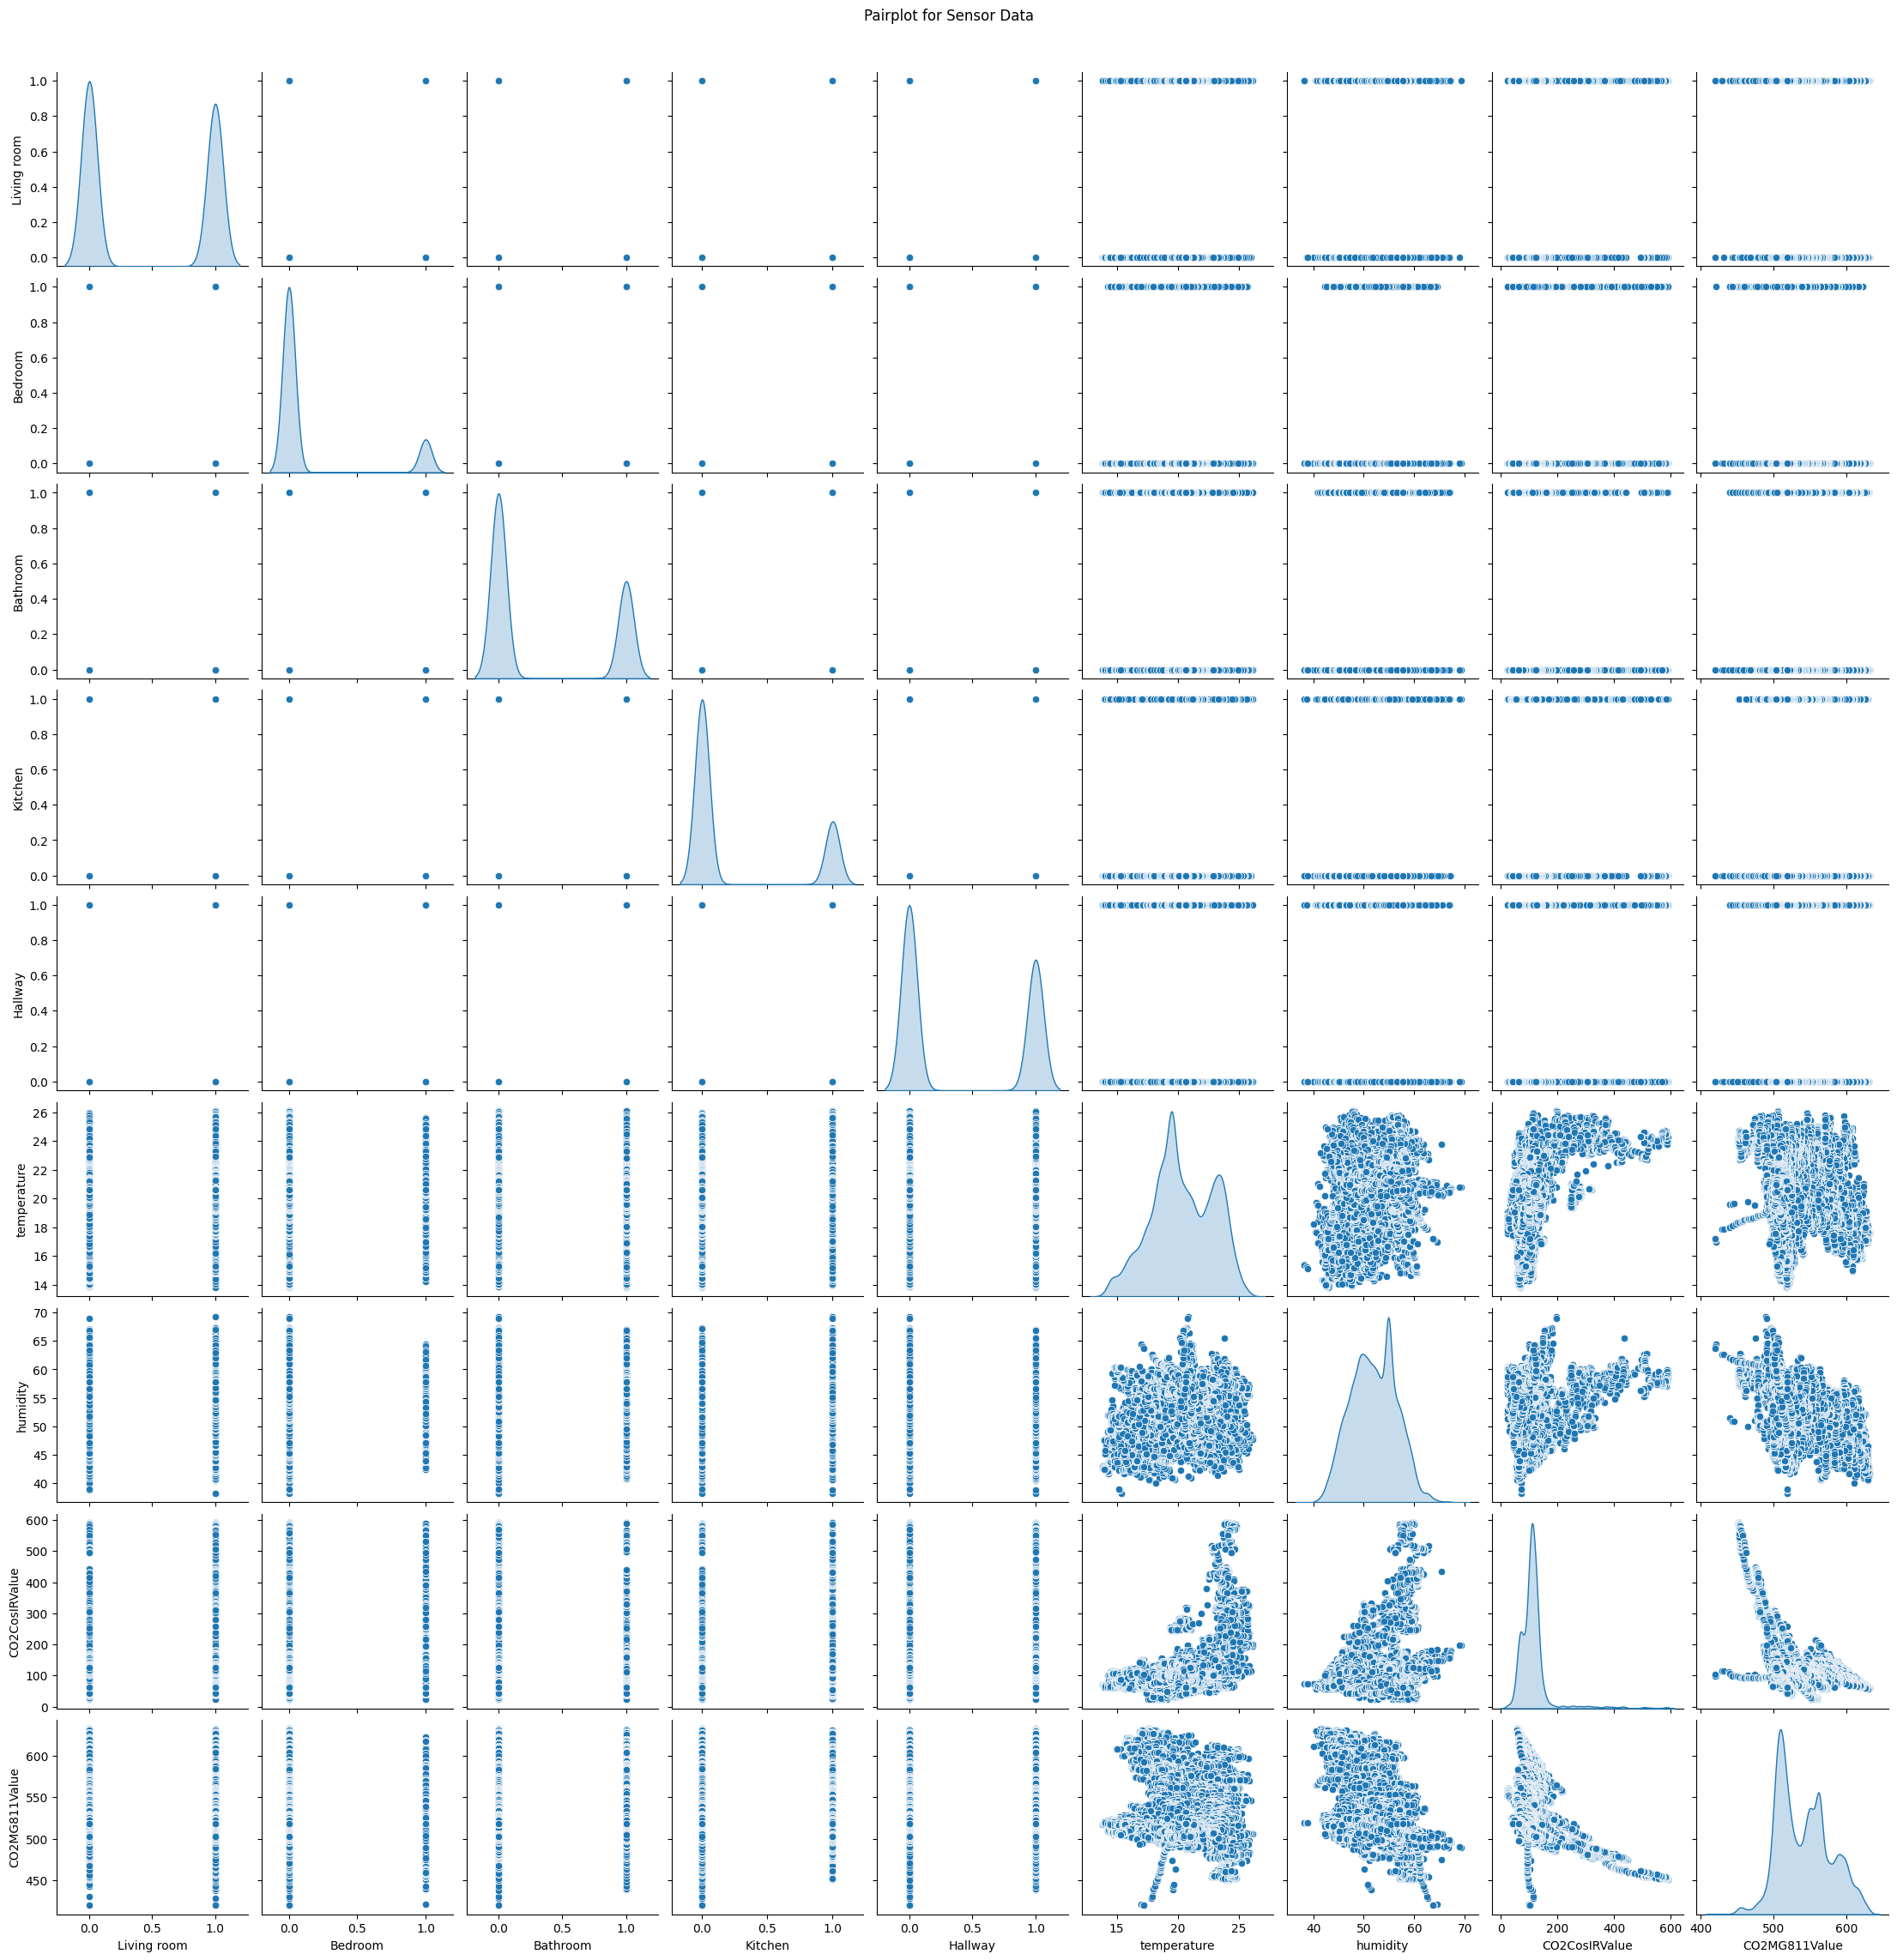

In [34]:
#Pairplot
sns.pairplot(merged_data[['Living room', 'Bedroom', 'Bathroom', 'Kitchen', 'Hallway', 'temperature', 'humidity', 'CO2CosIRValue', 'CO2MG811Value']], diag_kind='kde')
plt.suptitle('Pairplot for Sensor Data', y=1.02)
plt.show()


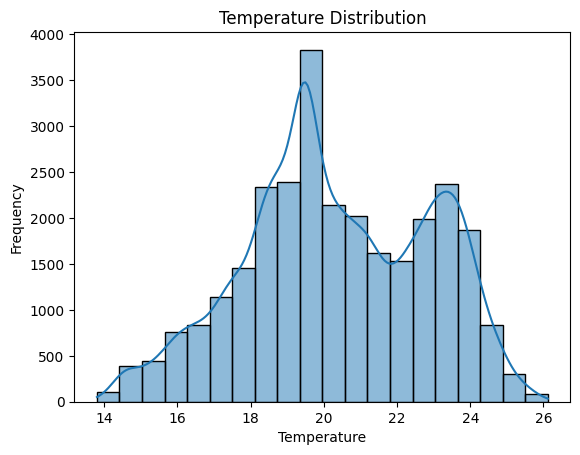

In [35]:
#Histplot
sns.histplot(merged_data['temperature'], bins=20, kde=True)
plt.title('Temperature Distribution')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()


<Axes: xlabel='Bedroom', ylabel='count'>

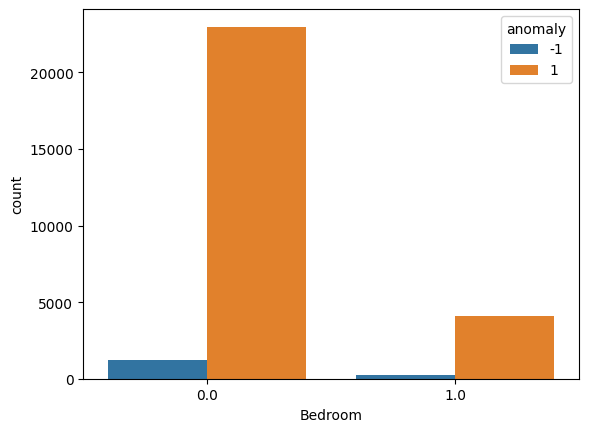

In [36]:
#Countplot
sns.countplot(x='Bedroom', hue='anomaly', data=merged_data)



In [37]:
# Analyze correlations between features
import seaborn as sns
correlation_matrix = merged_data[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


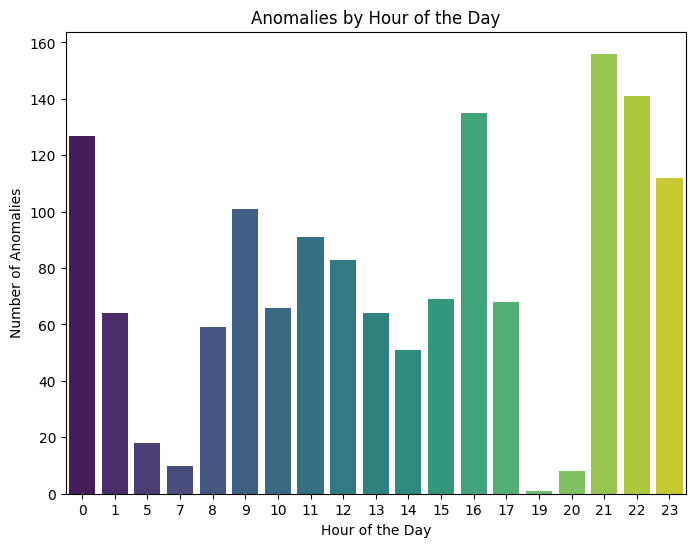

In [38]:
# Extract hour of the day from the timestamp and analyze anomalies by hour
anomalies['hour'] = anomalies['datetime'].dt.hour
anomalies_by_hour = anomalies.groupby('hour')['anomaly'].count()

plt.figure(figsize=(8, 6))
sns.barplot(x=anomalies_by_hour.index, y=anomalies_by_hour.values, palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Anomalies')
plt.title('Anomalies by Hour of the Day')
plt.show()



In [39]:
# 'merged_data' contains  dataset and 'anomaly' variable contains the output from Isolation Forest
X = merged_data[features]
anomaly = merged_data['anomaly']

# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 1. DBSCAN (Continuation)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_std)
# -1 indicates outliers in DBSCAN
dbscan_outliers = (dbscan_labels == -1)

# Further analysis or actions based on DBSCAN anomalies
for idx, is_anomaly in enumerate(dbscan_outliers):
    if is_anomaly:
        print(f"DBSCAN Anomaly detected at index {idx}.")

DBSCAN Anomaly detected at index 1535.
DBSCAN Anomaly detected at index 1563.
DBSCAN Anomaly detected at index 1638.
DBSCAN Anomaly detected at index 1732.
DBSCAN Anomaly detected at index 1733.
DBSCAN Anomaly detected at index 1734.
DBSCAN Anomaly detected at index 1826.
DBSCAN Anomaly detected at index 1934.
DBSCAN Anomaly detected at index 2088.
DBSCAN Anomaly detected at index 2089.
DBSCAN Anomaly detected at index 2090.
DBSCAN Anomaly detected at index 2154.
DBSCAN Anomaly detected at index 2387.
DBSCAN Anomaly detected at index 2388.
DBSCAN Anomaly detected at index 2389.
DBSCAN Anomaly detected at index 2595.
DBSCAN Anomaly detected at index 2596.
DBSCAN Anomaly detected at index 2598.
DBSCAN Anomaly detected at index 2657.
DBSCAN Anomaly detected at index 2693.
DBSCAN Anomaly detected at index 2694.
DBSCAN Anomaly detected at index 2695.
DBSCAN Anomaly detected at index 2696.
DBSCAN Anomaly detected at index 2697.
DBSCAN Anomaly detected at index 2698.
DBSCAN Anomaly detected a

In [40]:
# Apply DBSCAN
epsilon = 0.5
min_samples = 5
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
merged_data['cluster'] = dbscan.fit_predict(X_std)

# Anomalies will be points that are not assigned to any cluster (cluster label -1)
anomalies = merged_data[merged_data['cluster'] == -1]

# Now 'anomalies' DataFrame contains the anomalies detected by DBSCAN
print(anomalies)

                                 datetime  Living room  Bedroom  Bathroom  \
1535  2019-11-06 11:04:36.603002700+00:00          0.0      0.0       0.0   
1563  2019-11-06 13:13:32.687028100+00:00          0.0      0.0       0.0   
1638  2019-11-06 20:22:06.744011800+00:00          0.0      0.0       0.0   
1732  2019-11-07 07:16:08.491030500+00:00          1.0      0.0       0.0   
1733  2019-11-07 07:16:59.436062100+00:00          0.0      0.0       0.0   
...                                   ...          ...      ...       ...   
28328 2020-02-11 11:41:18.887077500+00:00          1.0      0.0       0.0   
28329 2020-02-11 11:41:27.176069900+00:00          1.0      0.0       0.0   
28330 2020-02-11 11:43:20.416064400+00:00          0.0      0.0       0.0   
28331 2020-02-11 11:43:48.888085900+00:00          0.0      0.0       0.0   
28332 2020-02-11 11:45:07.587090400+00:00          0.0      0.0       0.0   

       Kitchen  Hallway                        timestamp  temperature  \
15

In [41]:
#Fit the dbscan
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, metric='manhattan')
merged_data['cluster'] = dbscan.fit_predict(X_std)


In [42]:
#Silhouette score
from sklearn.metrics import silhouette_score
silhouette_avg = silhouette_score(X_std, merged_data['cluster'])
print("Silhouette Score:", silhouette_avg)


Silhouette Score: 0.44474455483541336


In [43]:
#calinski_harabasz_score
calinski_harabasz = calinski_harabasz_score(X_std, merged_data['cluster'])
print("Calinski-Harabasz Index:", calinski_harabasz)


Calinski-Harabasz Index: 163.09044189925618


In [44]:
# Define the autoencoder model
input_layer = Input(shape=(X_std.shape[1],))
encoder = Dense(32, activation='relu')(input_layer)
encoder = Dense(16, activation='relu')(encoder)
decoder = Dense(32, activation='relu')(encoder)
decoder = Dense(X_std.shape[1], activation='linear')(decoder)

autoencoder_model = Model(inputs=input_layer, outputs=decoder)
autoencoder_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder model
autoencoder_model.fit(X_std, X_std, epochs=50, batch_size=64, shuffle=True)

# Use the trained autoencoder to predict the samples
autoencoder_preds = autoencoder_model.predict(X_std)
mse = ((X_std - autoencoder_preds) ** 2).mean(axis=1)
threshold = mse.mean() + 2 * mse.std()  # Set threshold using mean and standard deviation

# Detect outliers using autoencoder
autoencoder_outliers = (mse > threshold)

# Further analysis or actions based on autoencoder anomalies
for idx, is_anomaly in enumerate(autoencoder_outliers):
    if is_anomaly:
        print(f"Autoencoder Anomaly detected at index {idx}.")


Epoch 1/50
445/445 [==============================] - 1s 1ms/step - loss: 0.1834
Epoch 2/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0134
Epoch 3/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0069
Epoch 4/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0049
Epoch 5/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0035
Epoch 6/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0025
Epoch 7/50
445/445 [==============================] - 1s 1ms/step - loss: 0.0019
Epoch 8/50
445/445 [==============================] - 0s 1ms/step - loss: 0.0014
Epoch 9/50
445/445 [==============================] - 1s 1ms/step - loss: 9.9751e-04
Epoch 10/50
445/445 [==============================] - 0s 1ms/step - loss: 7.0874e-04
Epoch 11/50
445/445 [==============================] - 1s 1ms/step - loss: 5.2266e-04
Epoch 12/50
445/445 [==============================] - 1s 1ms/step - loss: 3.8537e-04
Epoch 13/

In [45]:
# Calculate reconstruction loss on the test set
reconstruction_loss = ((X_std - autoencoder_preds) ** 2).mean(axis=1)
print(f"Reconstruction Loss on Test Set: {reconstruction_loss.mean():.2f}")


Reconstruction Loss on Test Set: 0.00


In [46]:
# Ground truth labels (1 for anomalies, 0 for normal)
y_true = [1 if is_anomaly else 0 for is_anomaly in autoencoder_outliers]

# Predicted labels (True for anomalies, False for normal)
y_pred = [1 if is_anomaly else 0 for is_anomaly in autoencoder_outliers]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")


Accuracy: 1.00
Precision: 1.00
Recall: 1.00
F1-score: 1.00


In [47]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix


array([[27725,     0],
       [    0,   753]])

In [48]:
# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Adjust parameters as needed

# Fit the model and predict outliers
outliers = lof.fit_predict(X)

# 'outliers' will contain the predicted labels: 1 for inliers (normal data points), -1 for outliers (anomalies)

# Add the 'outliers' array to your original dataset if needed
merged_data['outliers'] = outliers

# Print the number of anomalies detected
num_anomalies = len(merged_data[merged_data['outliers'] == -1])
print(f'Number of anomalies detected: {num_anomalies}')

Number of anomalies detected: 1423


In [49]:
# Print the number of anomalies detected
num_anomalies = len(merged_data[merged_data['outliers'] == -1])
print(f'Number of anomalies detected: {num_anomalies}')


Number of anomalies detected: 1423


In [50]:
#Model Evaluation LOF
true_labels = merged_data['anomaly']
predicted_labels = merged_data['outliers']

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-score: {f1:.2f}')


Accuracy: 0.90
Precision: 0.95
Recall: 0.95
F1-score: 0.95


In [51]:
# Initialize One-Class SVM model
from sklearn.model_selection import train_test_split
X_train, X_test, true_labels_train, true_labels_test = train_test_split(X_scaled, true_labels, test_size=0.2, random_state=42)

svm_model = OneClassSVM(nu=0.05, kernel='rbf', gamma=0.1)  # Adjust parameters as needed

# Fit the model only on the training data
svm_model.fit(X_train)

# Predict outliers/anomalies on the test set
predicted_labels = svm_model.predict(X_test)
predicted_labels[predicted_labels == 1] = 0  # Convert inliers to 0, outliers to -1

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels_test, predicted_labels)
precision_macro = precision_score(true_labels_test, predicted_labels, average='macro')
recall_macro = recall_score(true_labels_test, predicted_labels, average='macro')
f1_macro = f1_score(true_labels_test, predicted_labels, average='macro')

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision : {precision_macro:.2f}')
print(f'Recall : {recall_macro:.2f}')
print(f'F1-score : {f1_macro:.2f}')

Accuracy: 0.03
Precision : 0.17
Recall : 0.18
F1-score : 0.18
